# 3. Feature Selection

<div class="alert alert-block alert-info">

[1. The needed steps](#1st-bullet)<br>
- [1.1 Import the needed libraries](#2nd-bullet)<br>
- [1.2 Import the dataset](#3rd-bullet)<br>
- [1.3. Data pre-processing, data partition and scaling](#4th-bullet)<br>
    
[2. Feature Selection](#5th-bullet)<br>
- [2.1 Filter methods](#6th-bullet)<br>
    - [2.1.1 Univariate variables](#7th-bullet)<br>
    - [2.1.2 Spearman Correlation](#8th-bullet)<br>
    - [2.1.3 Chi-Square](#9th-bullet)<br>
- [2.2 Wrapper Methods](#10th-bullet)<br>
    - [2.2.1 RFE](#11th-bullet)<br>
- [2.3 Embedded Methods](#12th-bullet)<br>
    - [2.3.1 Lasso](#13th-bullet)<br>
- [2.4 Final Insights](#14th-bullet)<br>
    
</div>

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 1. The needed steps
    

    
</div>

<a class="anchor" id="2nd-bullet">

### 1.1. Import the needed libraries
    
</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data partition
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from regressors import stats

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="3rd-bullet">

### 1.2. Import the dataset
    
</a>

In [2]:
purchase = pd.read_csv('train.csv')
purchase.set_index('Access_ID', inplace = True)
purchase.head(3)

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
Access_ID,,,,,,,,,,,,,,,,
102863333,21-Mar-20,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
103117814,20-May-20,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
103201891,4-Dec-20,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


<a class="anchor" id="4th-bullet">


### 1.3. Data pre-processing, data partition and scaling

</a>



In [3]:
#fix data types
purchase.Type_of_Traffic = purchase.Type_of_Traffic.astype("str")
purchase.Browser = purchase.Browser.astype("str")

In [4]:
#Check the info of the dataset
purchase.info()
# record length of original dataset for later calculations
oglen=len(purchase)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        9999 non-null   object 
 1   AccountMng_Pages            9999 non-null   int64  
 2   AccountMng_Duration         9999 non-null   float64
 3   FAQ_Pages                   9999 non-null   int64  
 4   FAQ_Duration                9999 non-null   float64
 5   Product_Pages               9999 non-null   int64  
 6   Product_Duration            9999 non-null   float64
 7   GoogleAnalytics_BounceRate  9999 non-null   float64
 8   GoogleAnalytics_ExitRate    9999 non-null   float64
 9   GoogleAnalytics_PageValue   9999 non-null   float64
 10  OS                          9999 non-null   object 
 11  Browser                     9999 non-null   object 
 12  Country                     9999 non-null   object 
 13  Type_of_Traffic     

In [5]:
#isolating numeric variables
num_vars=purchase.select_dtypes(include=np.number).set_index(purchase.index)

## Outlier removal

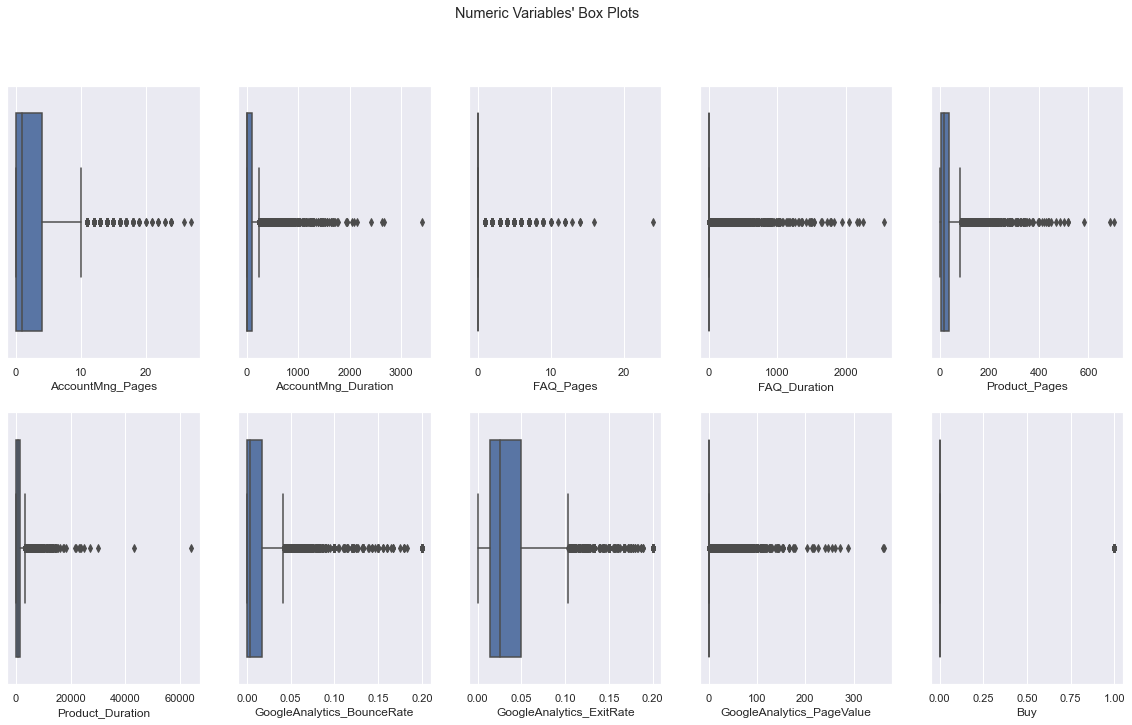

In [6]:
# plot outliers

sns.set()
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(num_vars.shape[1] / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [7]:
#function to automatically remove outliers, not currently in use
num_vars=purchase.select_dtypes(include=np.number).set_index(purchase.index).columns
def outliers(purchase,num_vars):
    for variable in num_vars:
        var_mean = purchase[variable].mean()
        var_std = purchase[variable].std()
        purchase=purchase.loc[purchase[variable] < var_mean + (5 * var_std)]
        purchase=purchase.loc[purchase[variable] > var_mean - (5 * var_std)]
    return purchase
#purchase = outliers(purchase,num_vars)

In [8]:
num_vars

Index(['AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'FAQ_Duration',
       'Product_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Buy'],
      dtype='object')

In [9]:
# Manual outlier removal.

filters1 = (
    (purchase['AccountMng_Duration']<=300)
    &(purchase['FAQ_Duration']<=2500)
    &(purchase['Product_Pages']<=550)
    &(purchase['Product_Duration']<=40000)
#    &(purchase['GoogleAnalytics_BounceRate']<=.16)
#    &(purchase['GoogleAnalytics_ExitRate']<=.16)
    &(purchase['GoogleAnalytics_PageValue']<=200)
)

purchase = purchase[filters1]

In [10]:
print('Percentage of data kept after removing outliers:', np.round(purchase.shape[0] / oglen, 4))

Percentage of data kept after removing outliers: 0.9339


In [11]:
#balance our data - will remove negatively labeled data until the number of positives and negatives are the same. 
negative = purchase.loc[purchase.Buy==0]
positive = purchase.loc[purchase.Buy==1]
negative_shrunk = negative[:len(positive)]
purchase = pd.concat([positive,negative_shrunk],axis=0)
purchase = shuffle(purchase)

In [12]:
#create dummy variables - same as one-hot encoding
purchase = pd.get_dummies(purchase, columns = ["Type_of_Traffic"])
purchase = purchase.drop(['Type_of_Traffic_15'], axis=1)
purchase = pd.get_dummies(purchase, columns = ["OS"])
purchase = purchase.drop(['OS_Ubuntu'], axis=1)

__`Step 4`__ Define the independent variables as __X__ and the dependent variable ('Survived') as __y__. <br>
- _Documentation pandas.DataFrame.drop():_ https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [13]:
X = purchase.drop(['Buy'], axis=1)
y = purchase['Buy']

__`Step 5`__ By using the method `train_test_split()` from sklearn.model_selection, split your dataset into train(70%) and validation(30%).<br>
- _Documentation sklearn.model_selection.train_test_split():_ https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state = 0, stratify = y, shuffle = True)

__`Step 6`__ There are missing values in the variable 'Cabin'. Fill those with 'Unknown'. <br>
- _Documentation pandas.DataFrame.fillna():_ https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

**_Note_**: You should not use any information from the validation / test dataset to fill the missing values. 
Let's imagine that you have missing values on age and you want to fill those missing values with the median. You should compute the median value of age for the train dataset (suppose is 35) and fill the missing values in train, validation and test set (if available) with the median in the train dataset (35).

__`Step 6`__ Depending on the feature selection technique used, the input variables can differ - some techniques work only with numerical variables while others with categorical data. Define a new object named a `X_train_num` where only the numerical variables are mantained, and a object named as `X_train_cat` with all the categorical independent variables. Do the same for the validation data.
- _Documentation pandas.DataFrame.select_dtypes():_ https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html

In [15]:
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
# DO IT for validation
X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

__`Step 7`__ Using the MinMaxScaler from sklearn, scale the numerical data between 0 and 1.
- _Documentation sklearn.model_selection.MinMaxScaler():_ https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array
# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_scaled.head(3)

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Type_of_Traffic_1,...,Type_of_Traffic_7,Type_of_Traffic_8,Type_of_Traffic_9,OS_Android,OS_Chrome OS,OS_Fedora,OS_MacOSX,OS_Other,OS_Windows,OS_iOS
Access_ID,,,,,,,,,,,,,,,,,,,,,
182417771,0.142857,0.263581,0.0,0.0,0.004556,0.001037,0.0000,0.1000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
207634768,0.000000,0.000000,0.0,0.0,0.018223,0.009468,0.0000,0.1250,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
371916008,0.000000,0.000000,0.0,0.0,0.013667,0.003433,0.1665,0.3335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


__`Step 7B`__ Using the scaler, scale the numerical validation data also between 0 and 1.

**_Note_**: In the same way you did for filling the missing values, the scaling should also consider only the training data. In that way, we are going to use the minimum and maximum values of the training dataset for each variable (the MinMaxScaler use those values to scale the data) to scale also the validation dataset.

In [17]:
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_scaled.head(3)

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Type_of_Traffic_1,...,Type_of_Traffic_7,Type_of_Traffic_8,Type_of_Traffic_9,OS_Android,OS_Chrome OS,OS_Fedora,OS_MacOSX,OS_Other,OS_Windows,OS_iOS
Access_ID,,,,,,,,,,,,,,,,,,,,,
780120824,0.095238,0.307176,0.2,0.383556,0.150342,0.119728,0.000,0.050,0.287291,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209338231,0.095238,0.298457,0.3,0.067320,0.093394,0.243305,0.022,0.136,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
646273726,0.000000,0.000000,0.0,0.000000,0.041002,0.033488,0.000,0.111,0.194485,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## 2. Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## 2.1. Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### 2.1.1. Univariate variables
    
</a>

__`Step 8`__ Check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.
- _Documentation pandas.DataFrame.var():_ https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.var.html

In [25]:
# check for univariate variables
X_train_num_scaled.var()

AccountMng_Pages              0.030698
AccountMng_Duration           0.019992
FAQ_Pages                     0.025677
FAQ_Duration                  0.015429
Product_Pages                 0.021284
Product_Duration              0.024568
GoogleAnalytics_BounceRate    0.037881
GoogleAnalytics_ExitRate      0.040824
GoogleAnalytics_PageValue     0.024293
Type_of_Traffic_1             0.142961
Type_of_Traffic_10            0.039034
Type_of_Traffic_11            0.021535
Type_of_Traffic_12            0.003340
Type_of_Traffic_13            0.042102
Type_of_Traffic_14            0.002388
Type_of_Traffic_2             0.232924
Type_of_Traffic_3             0.116429
Type_of_Traffic_4             0.079141
Type_of_Traffic_5             0.026542
Type_of_Traffic_6             0.030148
Type_of_Traffic_7             0.004290
Type_of_Traffic_8             0.039474
Type_of_Traffic_9             0.002864
dtype: float64

<a class="anchor" id="8th-bullet">

### 2.1.2. Spearman Correlation
    
</a>

__`Step 9`__ We are going to check now the spearman correlation between the variables. First we need to create a new dataframe with all the training data, but containing also the dependent variable, so we can check if any of the independent variables are correlated with the target. Name this new dataframe as `all_train_num`. 

In [21]:
all_train_num = X_train_num_scaled.join(y_train)
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
#build correlation matrix
cor_spearman = all_train_num.corr(method ='spearman')
cor_spearman

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Type_of_Traffic_1,...,Type_of_Traffic_8,Type_of_Traffic_9,OS_Android,OS_Chrome OS,OS_Fedora,OS_MacOSX,OS_Other,OS_Windows,OS_iOS,Buy
AccountMng_Pages,1.000000,0.919947,0.329208,0.322606,0.418807,0.373242,-0.081524,-0.333976,0.219924,-0.050760,...,0.045559,-0.009030,-0.023520,-0.024450,-0.024450,-0.032257,0.015627,0.035443,0.025387,0.208248
AccountMng_Duration,0.919947,1.000000,0.316169,0.310115,0.384455,0.362167,-0.105844,-0.355066,0.231436,-0.043351,...,0.044531,-0.010733,-0.002953,-0.023883,-0.023883,0.005370,0.010132,-0.002229,0.002515,0.201385
FAQ_Pages,0.329208,0.316169,1.000000,0.935943,0.345118,0.342084,0.050201,-0.133321,0.090829,-0.008558,...,-0.023477,0.029274,-0.017356,-0.012365,-0.012365,0.002850,-0.012365,0.014520,0.010360,0.123334
FAQ_Duration,0.322606,0.310115,0.935943,1.000000,0.319936,0.323623,0.021995,-0.158864,0.096612,-0.011148,...,-0.024201,0.032599,-0.016950,-0.011459,-0.011459,-0.006956,-0.011459,0.017678,0.018319,0.128977
Product_Pages,0.418807,0.384455,0.345118,0.319936,1.000000,0.876636,0.034747,-0.453034,0.220344,0.026913,...,-0.052374,-0.028676,-0.084830,-0.003116,-0.033457,-0.093746,-0.010722,0.137675,0.049513,0.250208
Product_Duration,0.373242,0.362167,0.342084,0.323623,0.876636,1.000000,0.016375,-0.399237,0.257915,0.035003,...,-0.026369,-0.020664,-0.086658,-0.001578,-0.031833,-0.083570,-0.008466,0.125125,0.060795,0.267879
GoogleAnalytics_BounceRate,-0.081524,-0.105844,0.050201,0.021995,0.034747,0.016375,1.000000,0.552351,-0.232340,0.153167,...,-0.071076,-0.026801,0.041499,-0.021154,-0.021154,0.178147,0.025709,-0.138776,-0.055711,-0.205092
GoogleAnalytics_ExitRate,-0.333976,-0.355066,-0.133321,-0.158864,-0.453034,-0.399237,0.552351,1.000000,-0.399838,0.131163,...,-0.039077,-0.015287,0.041219,-0.038270,0.016112,0.064837,0.017362,-0.067526,-0.028983,-0.334683
GoogleAnalytics_PageValue,0.219924,0.231436,0.090829,0.096612,0.220344,0.257915,-0.232340,-0.399838,1.000000,-0.081331,...,-0.000493,0.005788,-0.006950,0.036308,-0.019445,-0.147486,-0.019445,0.105826,0.028002,0.675146
Type_of_Traffic_1,-0.050760,-0.043351,-0.008558,-0.011148,0.026913,0.035003,0.153167,0.131163,-0.081331,1.000000,...,-0.096951,-0.028313,-0.096562,-0.010685,-0.010685,-0.015200,0.048620,0.088564,0.022928,-0.090515


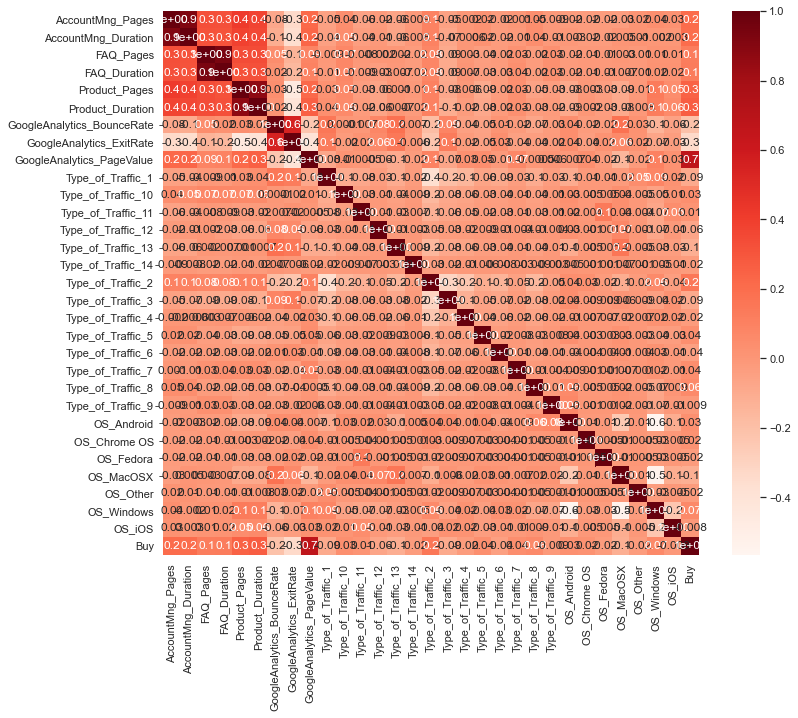

In [22]:
cor_heatmap(cor_spearman)

<a class="anchor" id="9th-bullet">

### 2.1.3. Chi-Square for categorical data

</a>

In [140]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [75]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Date is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Browser is NOT an important predictor. (Discard Browser from model)
Country is NOT an important predictor. (Discard Country from model)
Type_of_Traffic is IMPORTANT for Prediction
Type_of_Visitor is IMPORTANT for Prediction


<a class="anchor" id="10th-bullet">

### 2.1.4. Visualize the weight of the dependent variable in categorical data (EXTRA)

</a>

In this step, we are going to create two plots to check the weight that the dependent variable has in the different labels of a categorical variable. <br><br>
The first plot will represent the frequency of each value of the dependent variable in the different categories, and the second plot will make this representation more intuitive by checking the proportion of the presence of each label of the depedent variable in each category. <br><br>
Sometimes it can be useful not only to use more advanced techniques like the ones we saw previously, but also to explore visually the variables that we have, like we are going to do in this step.

While in the example given you can visualize this relation only to categorical data, you can create your own function where numerical data is split into bins to have a similar visualization.


__`Step 15`__ Create a function where you can visualize the proportion of the presence of each label of the dependent variable in each possible value of a categorical feature. Check the "weight" of the variable `Sex`.

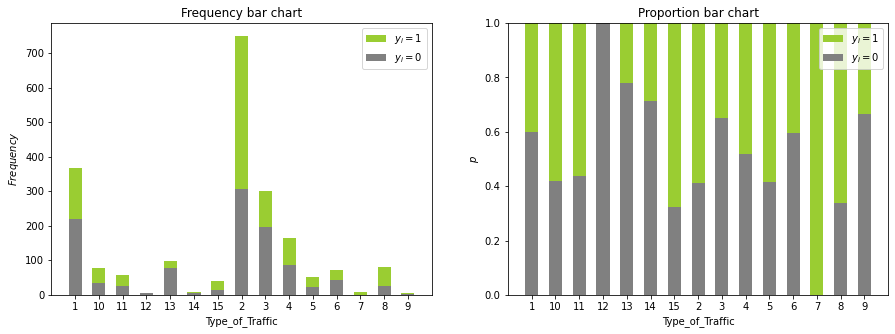

In [26]:
# first join all the training data
all_train = X_train.join(y_train)


def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()
    
bar_charts_categorical(all_train, "Type_of_Traffic", "Buy")

<a class="anchor" id="11th-bullet">

## 2.2. Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### 2.2.1. RFE
    
</a>

This time we are going to apply Recursive Feature Elimination (RFE / Backwards) that will allow to select the most important features to keep. The base estimator used will be a Logistic Regression.


__`Step 16`__ Using LogisticRegression, create a Logistic Regression Classifier instance called `model`
- _Documentation sklearn.linear_model.LogisticRegression():_ https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [90]:
# DO IT
model = LogisticRegression()

__`Step 17`__ Using RFE, create a RFE instance called `rfe` and initialize by defining the following parameters:
- `estimator` = model
- `n_features_to_select` = 3 <br> <br>

- _Documentation sklearn.feature_selection.RFE():_ https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [97]:
# DO IT
rfe = RFE(estimator = model, n_features_to_select = 3)

__`Step 18`__ Transform the data using RFE by applying the method `fit_transform()` to the instance `rfe`, where `X` should be assigned to your independent variables and `y` to the dependent variable and assign it to the object `X_rfe`

In [98]:
# DO IT
X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

__`Step 20`__ Check the variables that were selected by RFE as the most "important" ones by calling the attribute `support_` to `rfe`.

In [99]:
# DO IT
X_train_num_scaled.columns

Index(['AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'FAQ_Duration',
       'Product_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue'],
      dtype='object')

In [100]:
# DO IT
rfe.support_

array([False, False, False, False, False,  True, False,  True,  True])

__`Step 21`__ Check the ranking of the variables defined by RFE as the most "important" ones by applying the attribute `ranking_` to `rfe`.

In [101]:
# DO IT
rfe.ranking_

array([4, 7, 6, 5, 2, 1, 3, 1, 1])

__Step 22:__ Create an object (pandas Series) named `selected_features` that will have as index the `X_train_num` columns names and the `support_` attribute as value. <br>
- _Documentation pandas.Series():_ https://pandas.pydata.org/docs/reference/api/pandas.Series.html

In [102]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                  False
Product_Pages                 False
Product_Duration               True
GoogleAnalytics_BounceRate    False
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool

If you don't know apriori the number of features to select you can create a loop to check the score of the estimator using a different number of features. <br>
Below you have an example that will check the score of the estimator by chosing between 1 and 8 variables.

In [85]:
#no of features
nof_list=np.arange(1,7)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.821545


According to RFE, the numerical variables that we should keep for the final model are `GoogleAnalytics_ExitRate`, `GoogleAnalytics_PageValue`.

<a class="anchor" id="13th-bullet">

## 2.3. Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### 2.3.1. Lasso Regression
    
</a>

__Step 23:__ Create a function to plot the importance of the features named `plot_importance()` that should receive as parameters the "importance" of each variable (`coef`) and a `name` to define the title.  Define the following conditions/steps in the function:
- sort the values of `coef` asn assign it to the object `imp_coef`
- the size of the figure should be (8,10)
- create a matplotlib plot `kind = barh` to plot the `imp_coef`.
- Define the title as "Feature importance using" + _the name of the model_ `name` + " Model"

In [103]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

__Step 24:__ Using LassoCV, create a Lasso Regression instance called `reg`
- _Documentation sklearn.feature_selection.LassoCV():_ https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [104]:
# DO IT
reg = LassoCV()

__Step 25:__ Fit the data to `reg` by using the method `fit()` where `X` should be assigned to `data` and `y` to the dependent variable.

In [105]:
# DO IT
reg.fit(X_train_num_scaled, y_train)

LassoCV()

__Step 26:__ Create an object (pandas Series) named `coef` that will have as index the `data` columns names and the `coef_` attribute as value.

In [106]:
# DO IT
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
coef

AccountMng_Pages              0.191849
AccountMng_Duration           0.038776
FAQ_Pages                     0.072809
FAQ_Duration                  0.096815
Product_Pages                 0.120681
Product_Duration              0.379007
GoogleAnalytics_BounceRate    0.136558
GoogleAnalytics_ExitRate     -0.539056
GoogleAnalytics_PageValue     1.852997
dtype: float64

__Step 27:__ Check how many variables did Lasso picked (if the coef is different from 0) and how many variables did Lasso eliminated (if the coef is equal to 0).

In [107]:
# DO IT
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 0 variables


__Step 28:__ Sort the values of `coef` using the method `sort_values()`.

In [108]:
# DO IT
coef.sort_values()

GoogleAnalytics_ExitRate     -0.539056
AccountMng_Duration           0.038776
FAQ_Pages                     0.072809
FAQ_Duration                  0.096815
Product_Pages                 0.120681
GoogleAnalytics_BounceRate    0.136558
AccountMng_Pages              0.191849
Product_Duration              0.379007
GoogleAnalytics_PageValue     1.852997
dtype: float64

__Step 29:__ By calling the function `plot_importance()` that we created on step 15, plot the feature importance of the variables, by passing as parameters the object `coef` and the name `"Lasso"`

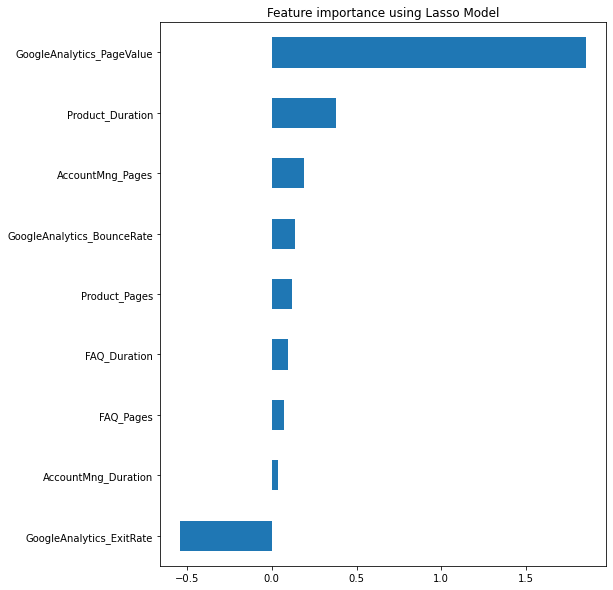

In [109]:
# DO IT
plot_importance(coef,'Lasso')